In [66]:
import pandas as pd
import re
import tempun
import matplotlib.pyplot as plt
import json

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

In [67]:
file_data = json.load(open("../data/ServiceAccountsKey.json"))
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(
    ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)

noscemus_gs = gc.open_by_url(
    "https://docs.google.com/spreadsheets/d/1ekf9RBfd4yqy0p0IWJ4SDk1kUT70hnoIVX1H6KPdIts/edit?usp=sharing")

In [2]:
cc_raw = pd.read_csv('../data/large_data/latin_raw.csv')

In [3]:
cc_raw["word_count"] = cc_raw["text"].apply(lambda x: len(x.split()))

In [68]:
cc_raw["word_count"].sum()

470180378

In [70]:
cc_raw.shape

(7819, 9)

In [5]:
cc_raw.drop("text", axis=1, inplace=True)

In [71]:
cc_raw.head(5)

,Unnamed: 0,title,author,year,word_count,not_before,not_after,is_earlymodern,random_dates
0,latin_xmls\10.xml,De facto Ungarie magne1236\n,Riccardus OFM,fl.1236,3340,1236.0,1236.0,False,"[1236, 1236, 1236, 1236, 1236, 1236, 1236, 123..."
1,latin_xmls\100.xml,De trinitate,Novatianus,fl. 260,44792,260.0,260.0,False,"[260, 260, 260, 260, 260, 260, 260, 260, 260, ..."
2,latin_xmls\10000.xml,De quadratura circuli,Franco Leodiensis,NaN,1648,NaN,NaN,False,None
3,latin_xmls\10001.xml,Epistola ad Berengarium,Frollandus Sylvanectensis,NaN,518,NaN,NaN,False,None
4,latin_xmls\10002.xml,Diplomata,Gervasius Remensis1055-1067,1055-1067,1532,1055.0,1067.0,False,"[1060, 1058, 1056, 1063, 1066, 1056, 1064, 106..."


In [7]:
# TO-DO
cc_raw["year"].apply(lambda x: "post" in str(x)).sum()

3

In [49]:
d = "c. 123"
dates_raw = [el for el in re.findall("(\d+)(BC)?", d)]
dates = []
for tup in dates_raw:
    if tup[1] == "BC":
        dates.append(int(tup[0]) * -1)
    else:
        dates.append(int(tup[0]))
dates

[123]

In [50]:

def get_dates(d):
    date_dict = {}
    try:
        dates_raw = [el for el in re.findall("(\d+)(BC)?", d)]
        dates = []
        for tup in dates_raw:
            if tup[1] == "BC":
                dates.append(int(tup[0]) * -1)
            else:
                dates.append(int(tup[0]))
    except:
        dates = []
    if len(dates)==1:
        dates = [dates[0], dates[0]]
    if len(dates)==2:
        date_dict = {"not_before" : dates[0], "not_after" : dates[1]}
    else:
        date_dict = {"not_before" : None, "not_after" : None}
    return date_dict   

In [51]:
cc_raw[cc_raw["year"].apply(lambda x: "BC" in str(x))]

,Unnamed: 0,title,author,year,word_count,not_before,not_after,is_earlymodern,random_dates
2000,latin_xmls\12144.xml,De agricultura,Varro,116BC-27BC,106464,116.0,116.0,False,"[116, 116, 116, 116, 116, 116, 116, 116, 116, ..."
2002,latin_xmls\12146.xml,De bello Africo,Ps-Caesar,c.50BC,26406,NaN,NaN,False,None
2003,latin_xmls\12147.xml,De bello Alexandrino,Ps-Caesar,c.50BC,21196,NaN,NaN,False,None
2004,latin_xmls\12148.xml,De bello Hispaniensi,Ps-Caesar,c.50BC,12368,NaN,NaN,False,None
2013,latin_xmls\12157.xml,De legibus,icero,106BC–43BC,56574,106.0,106.0,False,"[106, 106, 106, 106, 106, 106, 106, 106, 106, ..."
...,...,...,...,...,...,...,...,...,...
4388,latin_xmls\21315.xml,Theaetetus,Plato,c.425BC–347BC,71198,425.0,347.0,False,"[491, 453, 444, 454, 441, 441, 500, 500, 446, ..."
4389,latin_xmls\21316.xml,Theages,Plato,c.425BC–347BC,10973,425.0,347.0,False,"[434, 486, 493, 434, 484, 457, 470, 485, 428, ..."
4390,latin_xmls\21317.xml,Theogonia,Hesiodus,fl.c.700BC,14234,700.0,700.0,False,"[700, 700, 700, 700, 700, 700, 700, 700, 700, ..."
4391,latin_xmls\21318.xml,Timaeus,Plato,c.425BC–347BC,71756,425.0,347.0,False,"[452, 450, 458, 477, 440, 488, 472, 448, 457, ..."


In [52]:
cc_raw["dates_dict"] = cc_raw["year"].apply(get_dates)
cc_raw["not_before"] =  cc_raw["dates_dict"].apply(lambda x: x["not_before"])
cc_raw["not_after"] =  cc_raw["dates_dict"].apply(lambda x: x["not_after"])
cc_raw.drop(["dates_dict"], axis=1, inplace=True)

In [53]:
cc_raw.head()

,Unnamed: 0,title,author,year,word_count,not_before,not_after,is_earlymodern,random_dates
0,latin_xmls\10.xml,De facto Ungarie magne1236\n,Riccardus OFM,fl.1236,3340,1236.0,1236.0,False,"[1236, 1236, 1236, 1236, 1236, 1236, 1236, 123..."
1,latin_xmls\100.xml,De trinitate,Novatianus,fl. 260,44792,260.0,260.0,False,"[260, 260, 260, 260, 260, 260, 260, 260, 260, ..."
2,latin_xmls\10000.xml,De quadratura circuli,Franco Leodiensis,NaN,1648,NaN,NaN,False,None
3,latin_xmls\10001.xml,Epistola ad Berengarium,Frollandus Sylvanectensis,NaN,518,NaN,NaN,False,None
4,latin_xmls\10002.xml,Diplomata,Gervasius Remensis1055-1067,1055-1067,1532,1055.0,1067.0,False,"[1056, 1063, 1064, 1064, 1065, 1055, 1059, 106..."


In [54]:
cc_raw["is_earlymodern"] = ((cc_raw["not_after"]>=1501)
 & (cc_raw["not_before"]<=1800))

In [55]:
cc_raw["is_earlymodern"].sum()

702

In [56]:
cc_raw[cc_raw["is_earlymodern"]]["word_count"].sum()

62656530

In [57]:
"; ".join(list(cc_raw[cc_raw["is_earlymodern"]]["author"].unique()))

"Thomas Morus; Cartesius, Renatus; Desiderius Erasmus; Maurolycus, Franciscus; Kircher, Athanasius; Eberhard Schleusinger; Vesalius, Andreas; Leibniz, Gottfried Wilhelm; Copernicus, Nicolaus; Lavater, Ludwig; Cardanus, Hieronymus; Cantemir, Demetrius; Franciscus Suarez; Bene, Franz von; Benedictus Spinoza; Giambattista della Porta; Francis Bacon; Galilei, Galileo; Johannes Kepler; Kepler, Iohannes; Giordano Bruno; Gianni Battista Cantalicio; Baldassarre Castiglione; Giacomo Leopardi; Giambattista Giraldi Cinzio; Antonio Maria Conti; Gianfrancesco Pico della Mirandola; Uberto Foglietta; Lilio Gregorio Giraldi; Sannazaro, Iacopo; Ugolino Verino; Ugo Foscolo; Ludovico Ariosto; Torquato Tasso; Ludovico Carbone; Anonymus ; Andronicus, Parthenius Tranquillus; Cunichius, Raymondus; Leuakouicz, Raphael; Marulus Spalatensis, Marcus; Gradius, Stephanus; Verantius, Michael; Skerletz, Nicolaus; Pridojevich, Iohannes; Cibel, Valentin; Eborensis, Iacobus Flavius; Ritter, Paulus; Verhovac, Maximilian

In [58]:
cc_raw["random_dates"] = cc_raw.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=100), axis=1)

[[<matplotlib.patches.Polygon at 0x1689d8ee0>],

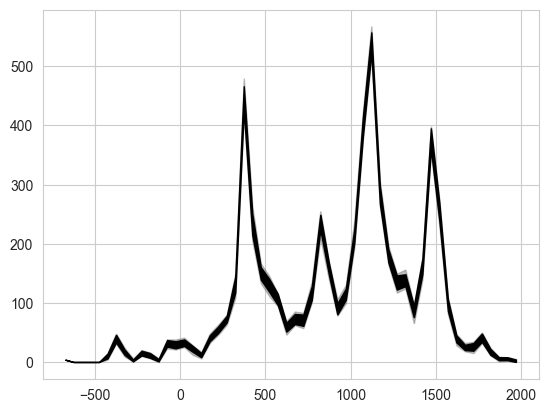

In [59]:
tempun.timeblocksplot_from_randoms(cc_raw["random_dates"])

In [60]:
def wordcount(timeblock_df, column="word_count"):
    """number of words in inscriptions within timeblock"""
    return timeblock_df[column].sum()
wordcounts_data = tempun.sim_data_by_function(cc_raw, 100, [-200, 1900, 50], wordcount)

In [61]:
wordcounts_data[0]

[((-200, -151), 347688),
 ((-150, -101), 365011),
 ((-100, -51), 2571854),
 ((-50, -1), 6292141),
 ((1, 50), 2420642),
 ((51, 100), 3472584),
 ((101, 150), 1615835),
 ((151, 200), 1380725),
 ((201, 250), 2488092),
 ((251, 300), 3498475),
 ((301, 350), 8956199),
 ((351, 400), 41142028),
 ((401, 450), 20996168),
 ((451, 500), 7590618),
 ((501, 550), 12287827),
 ((551, 600), 9342443),
 ((601, 650), 2210514),
 ((651, 700), 3838859),
 ((701, 750), 3436154),
 ((751, 800), 7536690),
 ((801, 850), 16671044),
 ((851, 900), 8741545),
 ((901, 950), 3575001),
 ((951, 1000), 3256896),
 ((1001, 1050), 5037828),
 ((1051, 1100), 25405018),
 ((1101, 1150), 37058015),
 ((1151, 1200), 23584035),
 ((1201, 1250), 37864260),
 ((1251, 1300), 14399520),
 ((1301, 1350), 9006542),
 ((1351, 1400), 8786797),
 ((1401, 1450), 3449144),
 ((1451, 1500), 6642859),
 ((1501, 1550), 11366302),
 ((1551, 1600), 27131926),
 ((1601, 1650), 9828546),
 ((1651, 1700), 4325051),
 ((1701, 1750), 697086),
 ((1751, 1800), 3983620),

[Text(0, 10000000, '10M'),
 Text(0, 20000000, '20M'),
 Text(0, 30000000, '30M'),
 Text(0, 40000000, '40M'),
 Text(0, 50000000, '50M')]

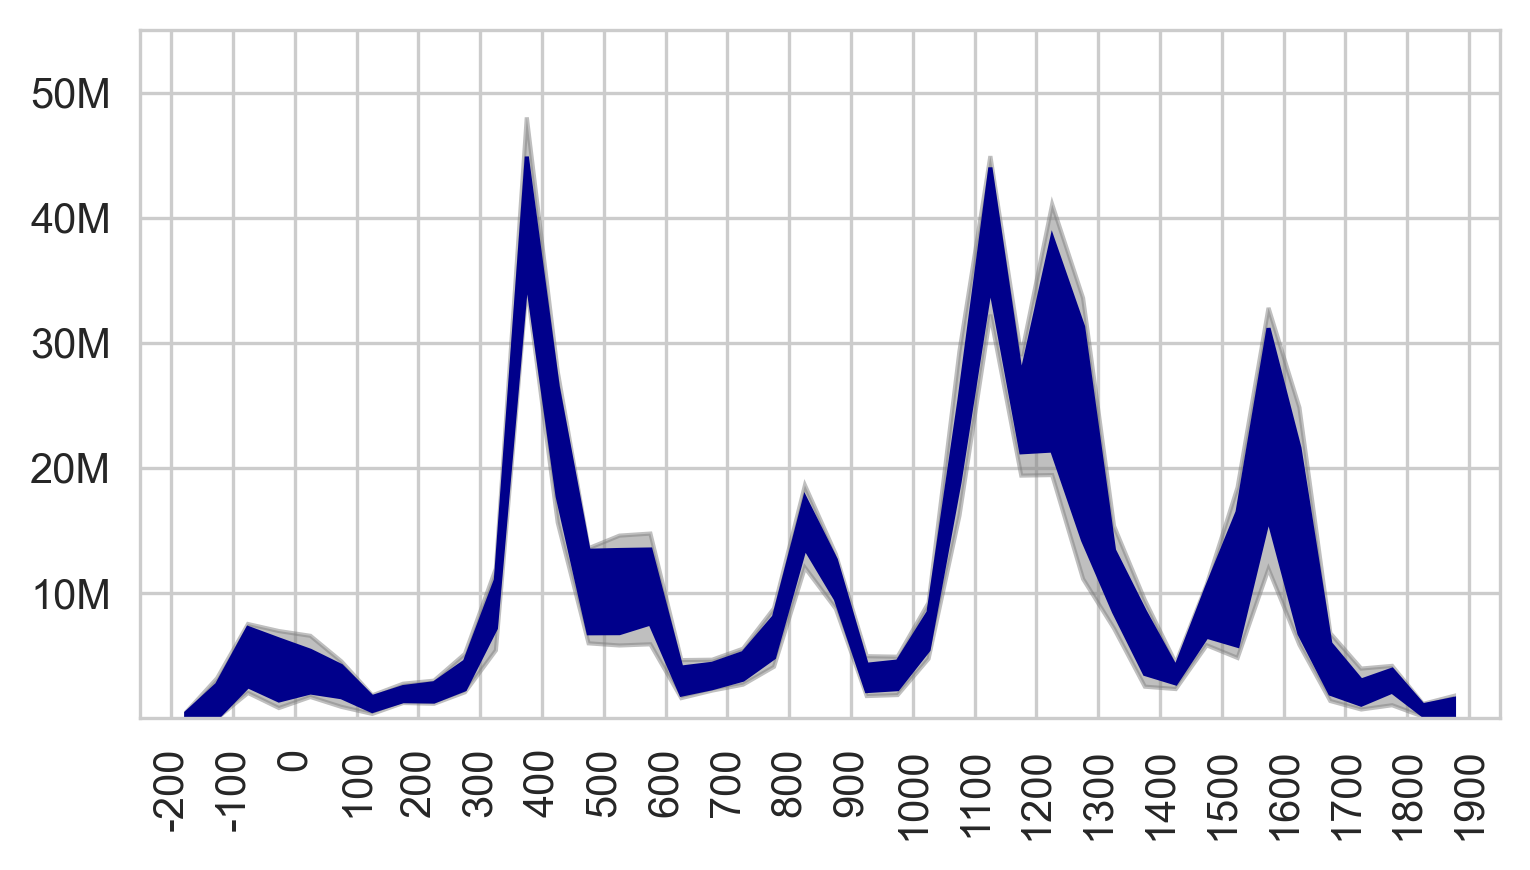

In [62]:
fig, ax = plt.subplots(figsize=(5.2, 3), dpi=300, tight_layout=True)
tempun.plot_timeblocks_data(wordcounts_data, ax=ax, color="darkblue")
ax.set_xticks(range(-200,2000,100))
ax.set_xticklabels([str(el) for el in range(-200,2000,100)], rotation=90)
ax.set_xlim(-250, 1950)

ax.set_ylim(0,55000000)
ax.set_yticks(range(10000000, 60000000, 10000000))
ax.set_yticklabels([str(el) + "M" for el in range(10, 60, 10)])


In [1]:
500000000 / 70000

7142.857142857143

In [63]:
fig.savefig("../figures/corpus-corporum_tempdist.png")

In [73]:
cc_raw.drop("random_dates", axis=1, inplace=True)

In [74]:
cc_raw.head(10)

,Unnamed: 0,title,author,year,word_count,not_before,not_after,is_earlymodern
0,latin_xmls\10.xml,De facto Ungarie magne1236\n,Riccardus OFM,fl.1236,3340,1236.0,1236.0,False
1,latin_xmls\100.xml,De trinitate,Novatianus,fl. 260,44792,260.0,260.0,False
2,latin_xmls\10000.xml,De quadratura circuli,Franco Leodiensis,NaN,1648,NaN,NaN,False
3,latin_xmls\10001.xml,Epistola ad Berengarium,Frollandus Sylvanectensis,NaN,518,NaN,NaN,False
4,latin_xmls\10002.xml,Diplomata,Gervasius Remensis1055-1067,1055-1067,1532,1055.0,1067.0,False
5,latin_xmls\10003.xml,Epistola ad Valcherum,Gozechinus Scholasticus,fl. 1059,26012,1059.0,1059.0,False
6,latin_xmls\10004.xml,Carmen de conflictu ovis et lini,Hermannus Contractus1013-1054,1013-1054,8816,1013.0,1054.0,False
7,latin_xmls\10005.xml,Chronicon,Hermannus Contractus1013-1054,1013-1054,161493,1013.0,1054.0,False
8,latin_xmls\10006.xml,De mensura astrolabii,Hermannus Contractus1013-1054,1013-1054,9363,1013.0,1054.0,False
9,latin_xmls\10007.xml,De utilitatibus astrolabii,Hermannus Contractus1013-1054,1013-1054,24633,1013.0,1054.0,False


In [75]:
set_with_dataframe(noscemus_gs.add_worksheet("corpus-corporum", 1,1), cc_raw)